In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                        roc_curve, auc, roc_auc_score, log_loss)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from hmm_ import ApplyHMM

In [2]:
data_path = "/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/pipeline/data_extracted_features/two_class_pp_3s_no.csv"
three_class_data_path = "/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/pipeline/data_extracted_features/three_class_pp_3s_no.csv"
features_df = pd.read_csv(data_path)
features = features_df.drop(columns=['center_time', 'start_time', 'end_time'])

#Three class
three_class_features = pd.read_csv(three_class_data_path)
three_class_features.drop(columns=['center_time', 'start_time', 'end_time'], inplace=True)

In [3]:
X = features.drop(columns=['label', 'experiment_id'])
y = features['label']
groups = features['experiment_id']

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train, groups_test = groups.iloc[train_idx], groups.iloc[test_idx]

In [4]:
# Three class
three_class_X = three_class_features.drop(columns=['label', 'experiment_id'])
three_class_y = three_class_features['label']
three_class_groups = three_class_features['experiment_id']

three_class_splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
three_class_train_idx, three_class_test_idx = next(three_class_splitter.split(three_class_X, three_class_y, three_class_groups))

three_class_X_train, three_class_X_test = three_class_X.iloc[three_class_train_idx], three_class_X.iloc[three_class_test_idx]
three_class_y_train, three_class_y_test = three_class_y.iloc[three_class_train_idx], three_class_y.iloc[three_class_test_idx]
three_class_groups_train, three_class_groups_test = three_class_groups.iloc[three_class_train_idx], groups.iloc[three_class_test_idx]

In [5]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [6]:
select_feature = SelectKBest(f_classif, k=20).fit(X_train, y_train)
selected_features_df = pd.DataFrame({'Feature':list(X_train.columns),
                                    'Scores':select_feature.scores_})

with pd.option_context('display.max_rows', None,
                    'display.max_columns', None):
    print(selected_features_df.sort_values(by='Scores', ascending=False))

                        Feature      Scores
95        gyr_z_spectral_spread  115.992366
81       gyr_y_hjorth_frequency  114.138602
98       gyr_z_hjorth_frequency  101.008025
78        gyr_y_spectral_spread   98.834848
11      acc_x_spectral_flatness   94.405520
68    gyr_y_permutation_entropy   93.839145
69       gyr_y_spectral_entropy   90.141721
94      gyr_z_spectral_centroid   86.658384
86       gyr_z_spectral_entropy   82.724752
6                     acc_x_min   82.603423
77      gyr_y_spectral_centroid   81.978244
5                     acc_x_rms   80.078069
13       acc_x_hjorth_frequency   79.466612
10        acc_x_spectral_spread   79.425324
85    gyr_z_permutation_entropy   77.121465
9       acc_x_spectral_centroid   76.723654
96      gyr_z_spectral_flatness   73.957919
73                    gyr_y_rms   72.468035
79      gyr_y_spectral_flatness   71.930521
71                    gyr_y_std   71.480443
89                  gyr_z_range   68.093340
90                    gyr_z_rms 

### RandomForest

In [7]:
model = RandomForestClassifier(
        n_estimators=315,
        max_depth=9,
        min_samples_split=13,
        min_samples_leaf=7,
        max_features='sqrt',
        bootstrap=False,
        class_weight='balanced',
        random_state=42)

In [8]:
X_train_selected = select_feature.transform(X_train)
X_test_selected = select_feature.transform(X_test)

In [9]:
model.fit(X_train_selected, y_train)

,n_estimators,315
,criterion,'gini'
,max_depth,9
,min_samples_split,13
,min_samples_leaf,7
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [10]:
classes = ['void', 'non-void']
y_pred = model.predict(X_test_selected)
y_pred_prob = model.predict_proba(X_test_selected)


# Convert back to original labels for the report
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred)


# Generate classification report with actual label names
report = classification_report(y_test_original, y_pred_original, labels=classes, target_names=classes)
print(report)

              precision    recall  f1-score   support

        void       0.78      0.44      0.57        81
    non-void       0.73      0.92      0.81       130

    accuracy                           0.74       211
   macro avg       0.75      0.68      0.69       211
weighted avg       0.75      0.74      0.72       211



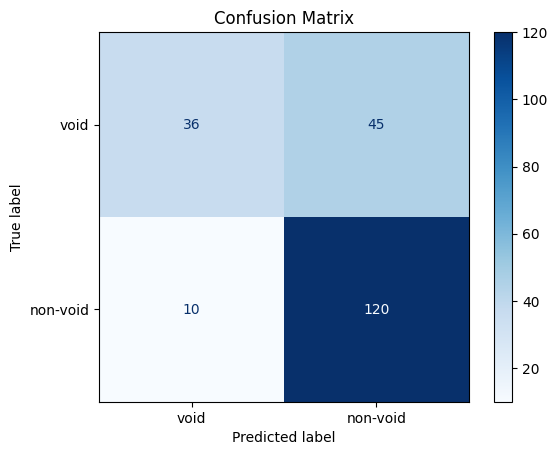

In [11]:
# Confusion matrix 
cm = confusion_matrix(y_test_original, y_pred_original, labels=classes)  # [void, non-void]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
plt.show()

Feature importance

                      Feature  Importance
13     gyr_y_hjorth_frequency    0.121840
17      gyr_z_spectral_spread    0.114364
1                   acc_x_min    0.095462
19     gyr_z_hjorth_frequency    0.086659
0                   acc_x_rms    0.081982
6   gyr_y_permutation_entropy    0.067073
12    gyr_y_spectral_flatness    0.052582
18    gyr_z_spectral_flatness    0.040505
14  gyr_z_permutation_entropy    0.038462
9                   gyr_y_rms    0.034334
10    gyr_y_spectral_centroid    0.034277
16    gyr_z_spectral_centroid    0.033226
8                   gyr_y_std    0.031175
15     gyr_z_spectral_entropy    0.028694
5      acc_x_hjorth_frequency    0.028237
11      gyr_y_spectral_spread    0.025963
4     acc_x_spectral_flatness    0.025269
2     acc_x_spectral_centroid    0.025227
3       acc_x_spectral_spread    0.018239
7      gyr_y_spectral_entropy    0.016430


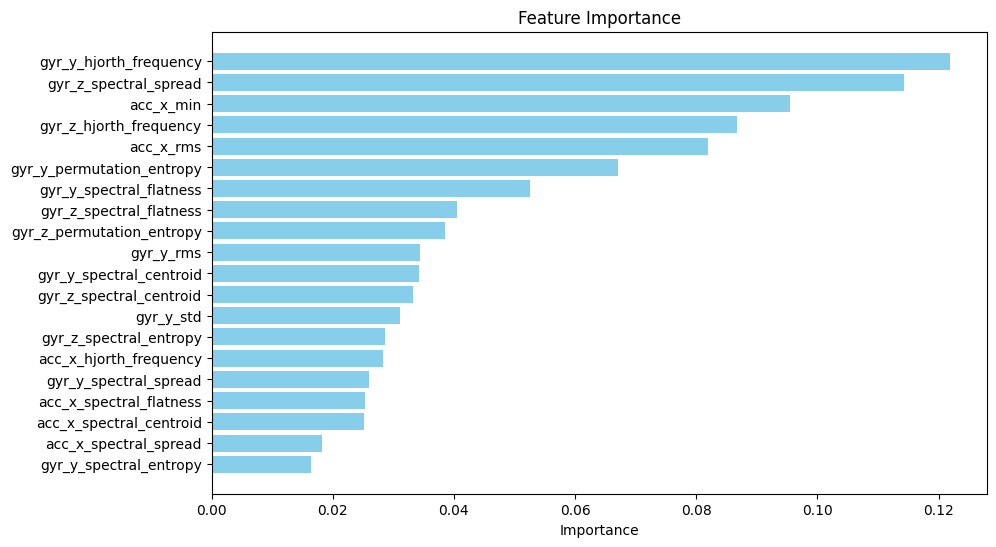

In [40]:
# feature importance
importances = model.feature_importances_
feature_names = X_train.columns[select_feature.get_support()]
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

#plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

## Overlay predictions on original plots

In [12]:
with open('../data/df_dict_imu.pkl', 'rb') as f:
    imu_dict = pickle.load(f)
with open('../data/df_dict_urineestimate_method1.pkl', 'rb') as f:
    urine_estimates_dict = pickle.load(f)
with open('../data/df_minze_dict.pkl', 'rb') as f:
    ground_truth_dict = pickle.load(f)
    
gender = pd.read_excel('../data/demographics_uroflowmetry.xlsx', index_col=0)
gender.drop(['Age', 'Waist Circumference (cm)', 'Height (cm)', 'Weight (Kg)', 'GD Vol (ml)', 'NOTES'], axis=1, inplace=True)
sex = gender['Gender']
sex = np.array(sex)


In [13]:
features_df = pd.read_csv("/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/pipeline/data_extracted_features/two_class_pp_3s_no.csv")

In [14]:
voids = {
    'subj_1_void7': 5, 
    'subj_2_void2': 9,
    'subj_2_void7': 14,
    'subj_3_void8': 20,
    'subj_5_void2': 25,
    'subj_5_void3': 26,
    'subj_8_void1': 30,
    'subj_15_void1': 40,
    'subj_16_void1': 41
}

In [15]:
# Keep everything together for easier analysis
# ==========================================================================================
# Dataframe containing test set information
# groups: ids of data in the two and three class test set
# y_test: true labels of the test set of the two class data
# y_pred: predicted labels from the classifier
# three_class_actual: true labels of the test set of the three class data 
# ==========================================================================================

test_results = pd.DataFrame({
    'group': groups_test,
    'actual': y_test,
    'predicted': y_pred,
    'three_class_actual': three_class_y_test
})

In [16]:
def plot_predictions_with_timing(features_df, predicted_labels, ax_pred):
    """
    Plot predictions using exact timing info from features DataFrame
    features_df and predicted_labels are already filtered for one instance
    """
    # Plot each prediction window
    void_label_added = False
    non_void_label_added = False
    
    for i, prediction in enumerate(predicted_labels):
        # Get timing info from features (convert seconds to ms to match your time axis)
        start_time = features_df.iloc[i]['start_time'] 
        # start_time = features_df.iloc[i]['center_time']
        end_time = features_df.iloc[i]['end_time'] 
        
        # Plot as colored spans
        if prediction == 1:  # Void prediction
            ax_pred.axvspan(start_time, end_time, alpha=0.7, color='lightgreen')
            void_label_added = True
        else:  # Non-void prediction
            ax_pred.axvspan(start_time, end_time, alpha=0.4, color='lightblue')
                        # label='Non-void Prediction' if not non_void_label_added else "")
            non_void_label_added = True
    
    # Set axis properties
    ax_pred.set_ylim(0, 1)
    ax_pred.set_ylabel('Predictions')
    ax_pred.set_yticks([0, 1])
    ax_pred.legend(loc='upper right')
    
    return ax_pred



In [17]:

for i_void_instance, void_instance in enumerate(voids.keys()):
    imu_data = imu_dict[void_instance]
    urine_estimates = urine_estimates_dict[void_instance]
    ground_truth = ground_truth_dict[void_instance]
    exp_id = voids[void_instance]
        
    # Urination event is the first and last time of the ground truth data
    urination_event = [ground_truth['Time'].iloc[0], ground_truth['Time'].iloc[-1]] 

    # Create a figure with 2 subplots (shared x-axis)
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # --- Top subplot: Accelerometer ---
    ax_top.plot(imu_data['time'], imu_data['acc_x'], color='0.2', label='acc_x')
    ax_top.plot(imu_data['time'], imu_data['acc_y'], color='0.5', label='acc_y')
    ax_top.plot(imu_data['time'], imu_data['acc_z'], color='0.7', label='acc_z')
    ax_top.set_ylabel('Acceleration (m/s²)')
    # Add title
    ax_top.set_title(f'IMU Data with Predictions for {void_instance} - {exp_id}', fontsize=14, fontweight='bold')
    ax_top.legend(loc='best')
    ax_top.grid(True)
        
    # Add vertical lines for urination event
    ax_top.axvline(x=urination_event[0], color='red', linestyle='--', alpha=0.7)
    ax_top.axvline(x=urination_event[1], color='red', linestyle='--', alpha=0.7)

    # Add phase labels at the top of the top subplot only
    x_min, x_max = ax_top.get_xlim()
    y_min, y_max = ax_top.get_ylim()

    # Pre-void label
    pre_void_center = (x_min + urination_event[0]) / 2
    ax_top.text(pre_void_center, y_max * 0.95, 'Non-void', ha='center', va='top', 
                fontsize=12, fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
        
    # Void label
    void_center = (urination_event[0] + urination_event[1]) / 2
    ax_top.text(void_center, y_max * 0.95, 'Void', ha='center', va='top', 
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))
        
    # Post-void label
    post_void_center = (urination_event[1] + x_max) / 2
    ax_top.text(post_void_center, y_max * 0.95, 'Non-void', ha='center', va='top', 
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
        
    # --- Bottom subplot: Gyroscope ---
    ax_bottom.plot(imu_data['time'], imu_data['gyr_x'], color='0.2', label='gyr_x', alpha=0.8)
    ax_bottom.plot(imu_data['time'], imu_data['gyr_y'], color='0.5', label='gyr_y', alpha=0.8)
    ax_bottom.plot(imu_data['time'], imu_data['gyr_z'], color='0.7', label='gyr_z', alpha=0.8)
    ax_bottom.set_ylabel('Angular Velocity (rad/s)')
    ax_bottom.set_xlabel('Time (ms)')
    ax_bottom.legend(loc='best')
    ax_bottom.grid(True)
        
    # Add vertical lines for urination event
    ax_bottom.axvline(x=urination_event[0], color='red', linestyle='--', alpha=0.7)
    ax_bottom.axvline(x=urination_event[1], color='red', linestyle='--', alpha=0.7)


    # --- Overlay predictions on bottom subplot ---
    ax_pred = ax_bottom.twinx()
    predicted_labels = test_results[test_results['group'] == exp_id]['predicted'].tolist()
    actual_labels = test_results[test_results['group'] == exp_id]['actual'].tolist()
    features_df_ = features_df[features_df['experiment_id'] == exp_id]
    print(f"Experiment ID: {exp_id}; Instance: {void_instance}")
    print(predicted_labels)
    plot_predictions_with_timing(features_df_, predicted_labels, ax_pred)


    # Add legend that combines both axes# model.fit(X_train, y_train)

    lines1, labels1 = ax_bottom.get_legend_handles_labels()
    lines2, labels2 = ax_pred.get_legend_handles_labels()
    ax_bottom.legend(lines1 + lines2, labels1 + labels2, loc='best')
        
        
    path = '/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/classifiers_to_hmm/plots/rf_3s/two'
    # Save plot   
    if not os.path.exists(path):
        os.mkdir(path)
        filename = os.path.join(path, f'{void_instance}({voids[void_instance]})_overlay.png')
        plt.savefig(filename)
    else:
        filename = os.path.join(path, f'{void_instance}({voids[void_instance]})_overlay.png')
        plt.savefig(filename)
    plt.close()

Experiment ID: 5; Instance: subj_1_void7
[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0]


/tmp/ipykernel_97000/1300223752.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_pred.legend(loc='upper right')


Experiment ID: 9; Instance: subj_2_void2
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0]
Experiment ID: 14; Instance: subj_2_void7
[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
Experiment ID: 20; Instance: subj_3_void8
[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]
Experiment ID: 25; Instance: subj_5_void2
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Experiment ID: 26; Instance: subj_5_void3
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Experiment ID: 30; Instance: subj_8_void1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
Experiment ID: 40; Instance: subj_15_void1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Experiment ID: 41; Instance: subj_16_void1
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


# HMM
Transform binary classifier outputs (non-void, void) into 3-class predictions (pre-void, void, post-void) using HMM temporal structure.

KEY IDEA: The HMM learns that:
- Non-void BEFORE void -> pre-void
- Void -> void
- Non-void AFTER void -> post-void

In [18]:
# Convert classification probabilities into dataframe
prob_classes = ['non-void', 'void']
predictions_prob_df = pd.DataFrame(y_pred_prob, columns=prob_classes)
predictions_prob_df['experiment_id'] = groups_test.values

In [19]:
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None):
    print(predictions_prob_df)

     non-void      void  experiment_id
0    0.911732  0.088268              5
1    0.720245  0.279755              5
2    0.679163  0.320837              5
3    0.695240  0.304760              5
4    0.640049  0.359951              5
5    0.258568  0.741432              5
6    0.181311  0.818689              5
7    0.699663  0.300337              5
8    0.355101  0.644899              5
9    0.677210  0.322790              5
10   0.651223  0.348777              5
11   0.846935  0.153065              9
12   0.724553  0.275447              9
13   0.778634  0.221366              9
14   0.216686  0.783314              9
15   0.293841  0.706159              9
16   0.427511  0.572489              9
17   0.281367  0.718633              9
18   0.295600  0.704400              9
19   0.259430  0.740570              9
20   0.457021  0.542979              9
21   0.332380  0.667620              9
22   0.498387  0.501613              9
23   0.612374  0.387626              9
24   0.240704  0.759296  

In [20]:
three_true = test_results['three_class_actual']


#### Improve the HMM implementation.
1. Learn transition matrix from training set labels of the 3-class classification.
2. Use full probability distribution [non-void, void] as 2D observations.
3. Switch to Gaussion HMM to handle continuous probabilities.
4. Remove the 0.30 threshold - let the HMM learn optimal boundaries.

In [21]:
data_path = "/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/pipeline/data_extracted_features/three_class_pp_3s_no.csv"
features = pd.read_csv(data_path)

X = features.drop(columns=['label', 'experiment_id'])
label_group = features[['label', 'experiment_id', 'center_time', 'start_time', 'end_time']]

groups = features['experiment_id']
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, label_group, groups))

df_train, df_test = label_group.iloc[train_idx], label_group.iloc[test_idx]
classes = ['pre-void', 'void', 'post-void']

In [22]:
df_test_times = df_test[['center_time', 'start_time', 'end_time']].reset_index()

In [23]:
predictions_prob_df_ =  pd.concat([predictions_prob_df, df_test_times], axis=1).drop(columns=['index'])# add the times to the predictions dataframe to enable the time sorting which maintains the temporal nature of the states

In [24]:
predictions_prob_df_

,non-void,void,experiment_id,center_time,start_time,end_time
0,0.911732,0.088268,5,1.5,0.0,3.0
1,0.720245,0.279755,5,4.5,3.0,6.0
2,0.679163,0.320837,5,7.5,6.0,9.0
3,0.695240,0.304760,5,10.5,9.0,12.0
4,0.640049,0.359951,5,13.5,12.0,15.0
...,...,...,...,...,...,...
206,0.339133,0.660867,41,25.5,24.0,27.0
207,0.483064,0.516936,41,28.5,27.0,30.0
208,0.683643,0.316357,41,31.5,30.0,33.0
209,0.457404,0.542596,41,34.5,33.0,36.0


In [25]:
apply_hmm = ApplyHMM(df_train, df_test, predictions_prob_df_)

In [26]:
best_test_state_preds, best_model, best_score, best_seed, transition_matrix, startprob = apply_hmm.improved_void_detection()
state_preds = best_test_state_preds['predicted_state'].values

In [27]:
state_preds

array(['pre-void', 'pre-void', 'pre-void', 'pre-void', 'void', 'void',
       'void', 'void', 'void', 'void', 'void', 'pre-void', 'pre-void',
       'pre-void', 'void', 'void', 'void', 'void', 'void', 'void', 'void',
       'void', 'void', 'void', 'void', 'void', 'void', 'void', 'void',
       'void', 'void', 'void', 'void', 'post-void', 'post-void',
       'post-void', 'post-void', 'pre-void', 'pre-void', 'pre-void',
       'pre-void', 'pre-void', 'pre-void', 'void', 'void', 'void', 'void',
       'void', 'void', 'void', 'void', 'post-void', 'post-void',
       'post-void', 'post-void', 'post-void', 'post-void', 'post-void',
       'pre-void', 'pre-void', 'pre-void', 'void', 'void', 'void', 'void',
       'void', 'void', 'void', 'post-void', 'pre-void', 'pre-void',
       'pre-void', 'pre-void', 'pre-void', 'pre-void', 'pre-void',
       'pre-void', 'void', 'void', 'void', 'void', 'void', 'void', 'void',
       'void', 'void', 'void', 'post-void', 'post-void', 'post-void',
       'pos

In [28]:
transition_matrix

array([[0.77777778, 0.22222222, 0.        ],
       [0.        , 0.86721992, 0.13278008],
       [0.        , 0.        , 1.        ]])

In [29]:
startprob

array([1., 0., 0.])

In [30]:
# Generate classification report with actual label names
report = classification_report(three_true, state_preds, labels=classes, target_names=classes)
print(report)

              precision    recall  f1-score   support

    pre-void       0.79      0.93      0.85        41
        void       0.78      0.85      0.81        81
   post-void       0.97      0.81      0.88        89

    accuracy                           0.85       211
   macro avg       0.85      0.86      0.85       211
weighted avg       0.86      0.85      0.85       211



In [31]:
# I did this to confirm why post-void activities were being classified as pre-void even though the temporal nature or the HMM forbids that.

# Findings
#=================


true_pred_df = pd.DataFrame({
    "true_three_class_labels":three_true.to_list(), 
    "hmm_predictions":state_preds
    })

In [32]:
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None):
    print(true_pred_df)

    true_three_class_labels hmm_predictions
0                  pre-void        pre-void
1                  pre-void        pre-void
2                      void        pre-void
3                      void        pre-void
4                      void            void
5                      void            void
6                      void            void
7                      void            void
8                 post-void            void
9                 post-void            void
10                post-void            void
11                 pre-void        pre-void
12                 pre-void        pre-void
13                 pre-void        pre-void
14                 pre-void            void
15                     void            void
16                     void            void
17                     void            void
18                     void            void
19                     void            void
20                     void            void
21                     void     

In [38]:
# Confusion matrix 
cm = confusion_matrix(three_true, state_preds, labels=classes)  # [void, non-void]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix: 3s_RandomForest--->HMM')

file_path = "/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/classifiers_to_hmm/plots/confusion_matrix/rf_3s_hmm.png"
plt.savefig(file_path)
plt.close()
plt.show()

In [34]:
state_pred_enc = label_encoder.fit_transform(state_preds).tolist()

In [35]:
test_results_copy = test_results
test_results_copy['hmm_pred'] = state_pred_enc

In [36]:
def plot_predictions_with_timing_three_class(features_df, predicted_labels, ax_pred):
    """
    Plot predictions using exact timing info from features DataFrame
    features_df and predicted_labels are already filtered for one instance
    """
    # Plot each prediction window
    void_label_added = False
    post_void_label_added = False
    pre_void_label_added = False
    
    for i, prediction in enumerate(predicted_labels):
        # Get timing info from features (convert seconds to ms to match your time axis)
        start_time = features_df.iloc[i]['start_time'] 
        # start_time = features_df.iloc[i]['center_time']
        end_time = features_df.iloc[i]['end_time'] 
        
        # Plot as colored spans
        if prediction == 2:  # Void prediction
            ax_pred.axvspan(start_time, end_time, alpha=0.7, color='lightgreen')
            void_label_added = True
        elif prediction == 0:  # Post void prediction
            ax_pred.axvspan(start_time, end_time, alpha=0.7, color='lightcoral')
            post_void_label_added = True
        elif prediction == 1:  # Pre void prediction
            ax_pred.axvspan(start_time, end_time, alpha=0.7, color='lightblue')
            pre_void_label_added = True

    
    # Set axis properties
    ax_pred.set_ylim(0, 1)
    ax_pred.set_ylabel('Predictions')
    ax_pred.set_yticks([0, 1])
    ax_pred.legend(loc='upper right')
    
    return ax_pred

Experiment ID: 5; Instance: subj_1_void7
[1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]


/tmp/ipykernel_97000/953194155.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_pred.legend(loc='upper right')


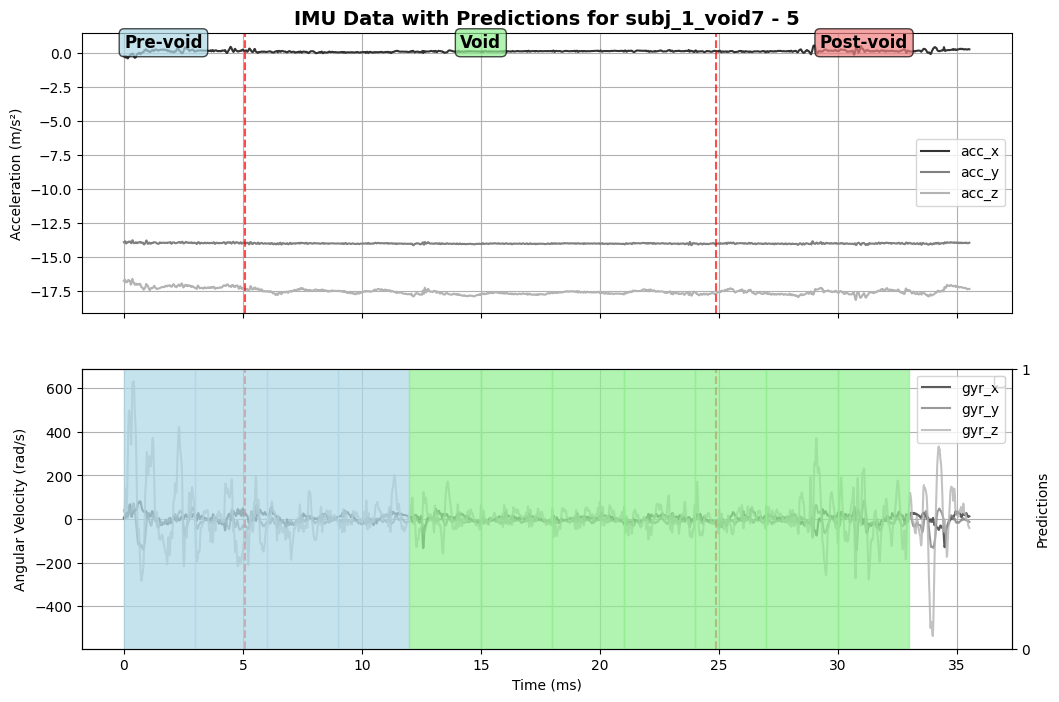

Experiment ID: 9; Instance: subj_2_void2
[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0]


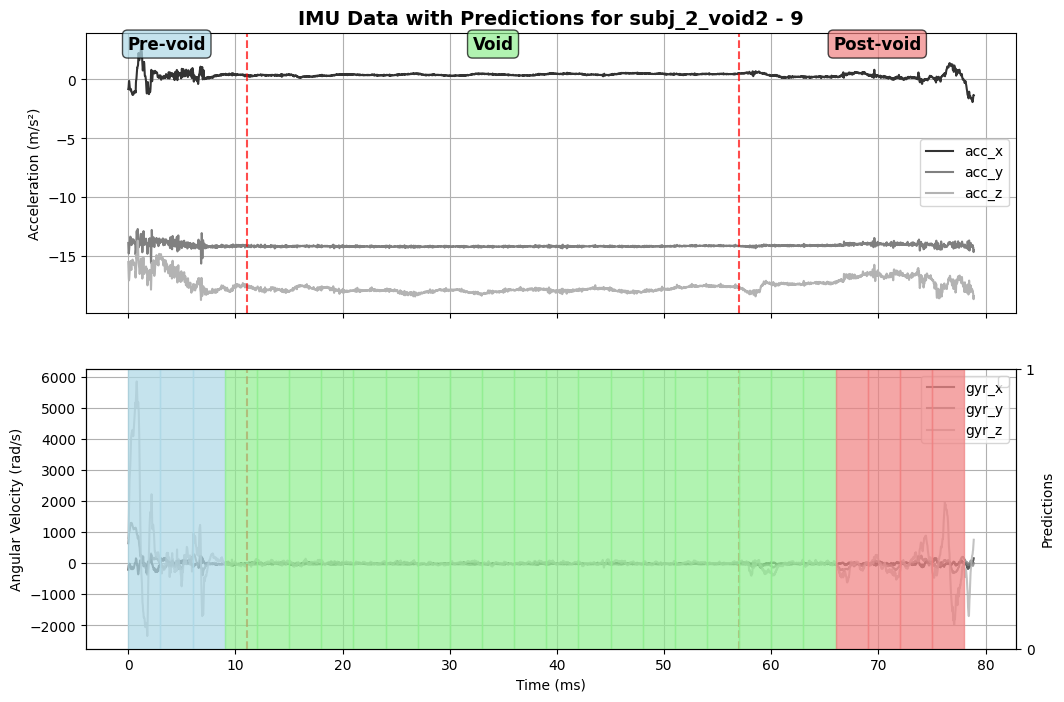

Experiment ID: 14; Instance: subj_2_void7
[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0]


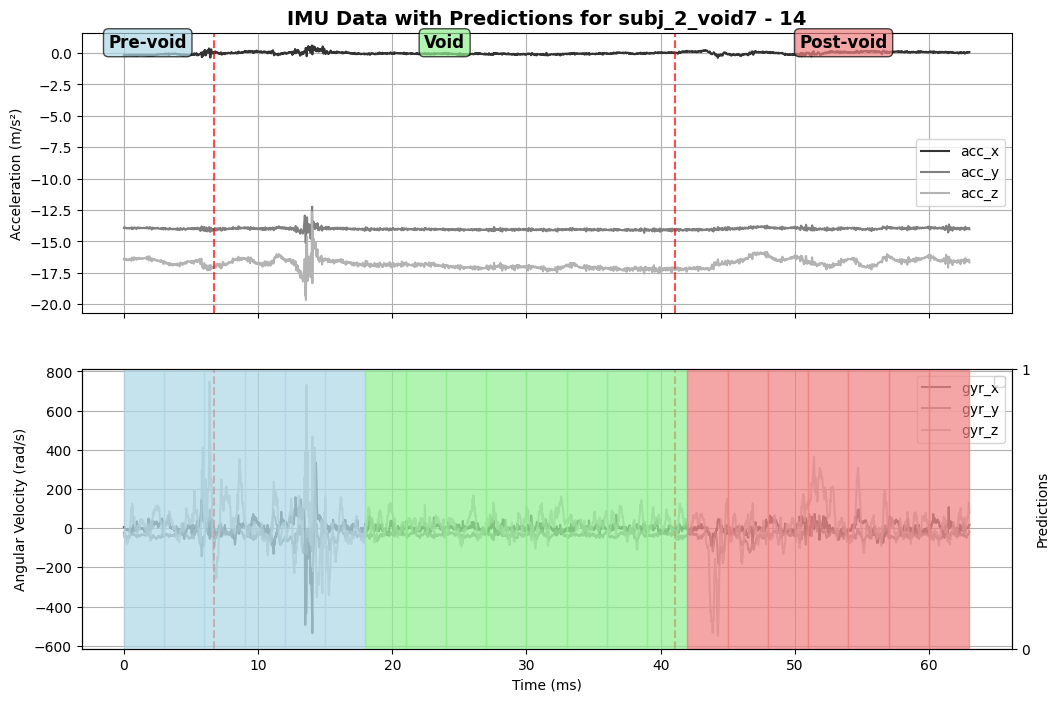

Experiment ID: 20; Instance: subj_3_void8
[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0]


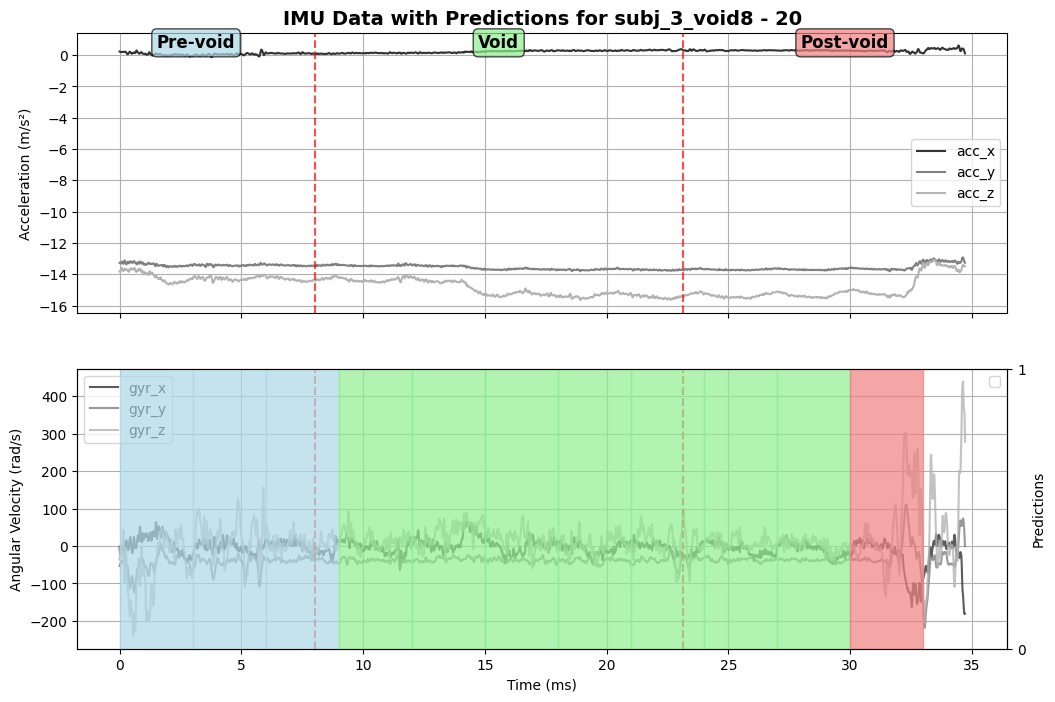

Experiment ID: 25; Instance: subj_5_void2
[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]


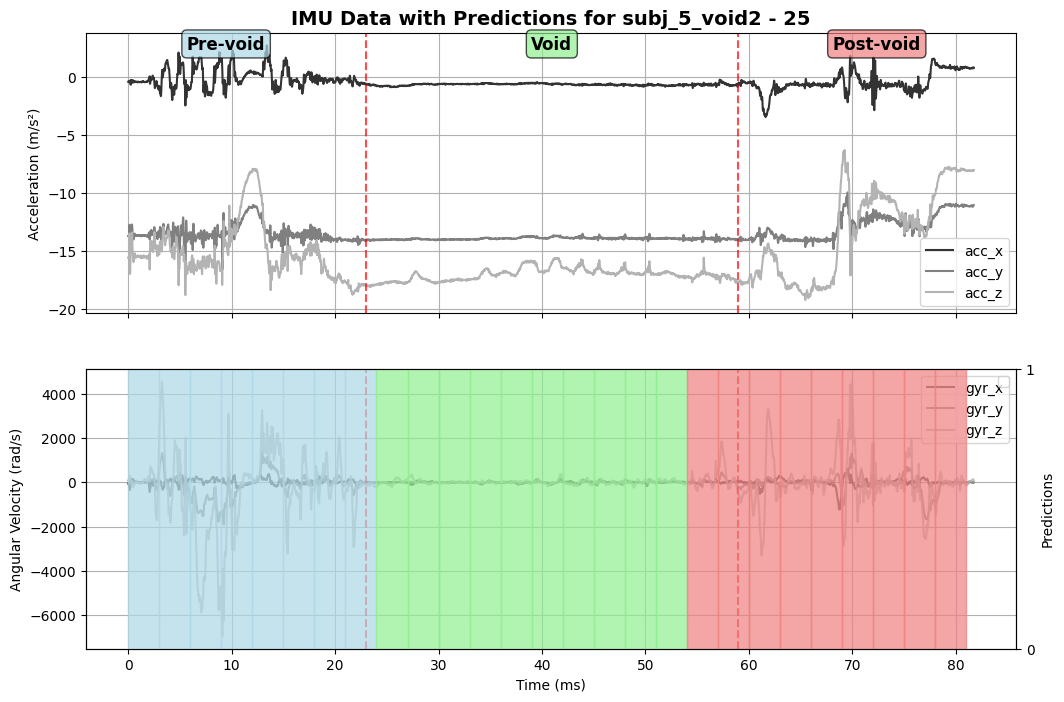

Experiment ID: 26; Instance: subj_5_void3
[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


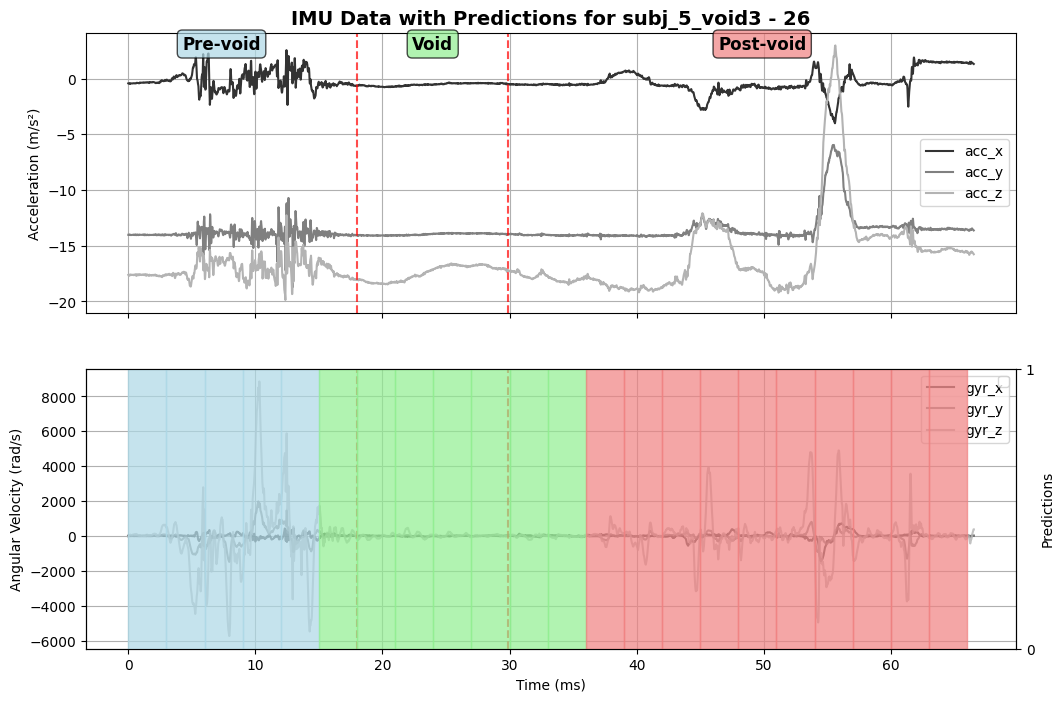

Experiment ID: 30; Instance: subj_8_void1
[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]


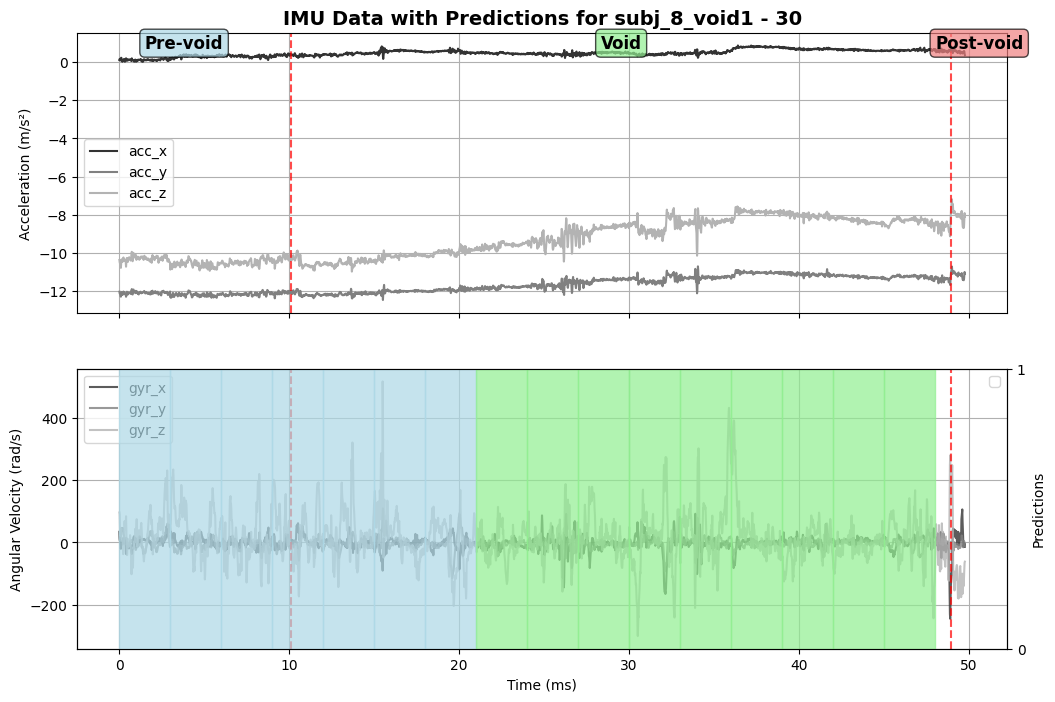

Experiment ID: 40; Instance: subj_15_void1
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


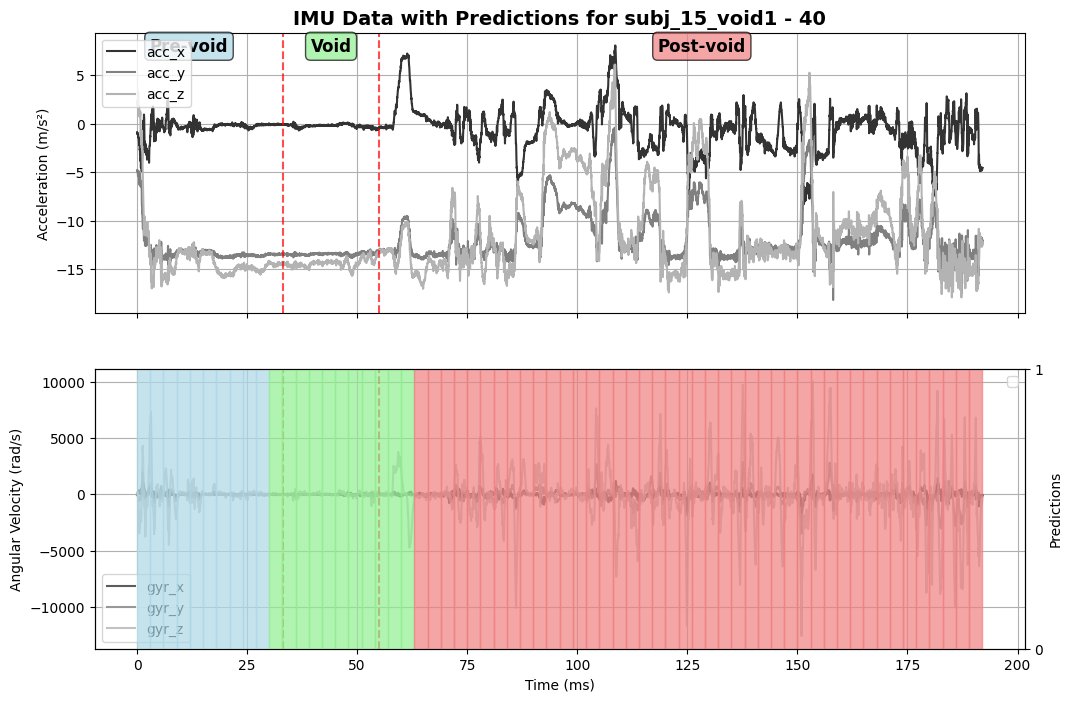

Experiment ID: 41; Instance: subj_16_void1
[1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


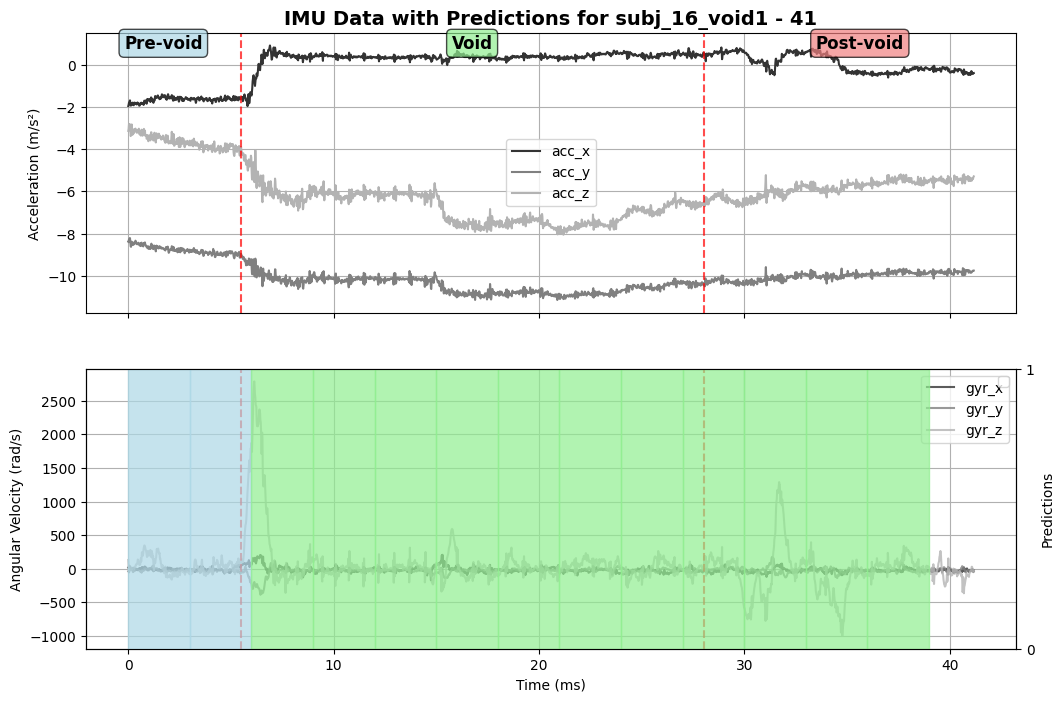

In [37]:
for i_void_instance, void_instance in enumerate(voids.keys()):
    imu_data = imu_dict[void_instance]
    urine_estimates = urine_estimates_dict[void_instance]
    ground_truth = ground_truth_dict[void_instance]
    exp_id = voids[void_instance]
    
    # Urination event is the first and last time of the ground truth data
    urination_event = [ground_truth['Time'].iloc[0], ground_truth['Time'].iloc[-1]] 
    
    # Create a figure with 2 subplots (shared x-axis)
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # --- Top subplot: Accelerometer ---
    ax_top.plot(imu_data['time'], imu_data['acc_x'], color='0.2', label='acc_x')
    ax_top.plot(imu_data['time'], imu_data['acc_y'], color='0.5', label='acc_y')
    ax_top.plot(imu_data['time'], imu_data['acc_z'], color='0.7', label='acc_z')
    ax_top.set_ylabel('Acceleration (m/s²)')
    ax_top.set_title(f'IMU Data with Predictions for {void_instance} - {exp_id}', fontsize=14, fontweight='bold')
    ax_top.legend(loc='best')
    ax_top.grid(True)
    
    # Add vertical lines for urination event
    ax_top.axvline(x=urination_event[0], color='red', linestyle='--', alpha=0.7)
    ax_top.axvline(x=urination_event[1], color='red', linestyle='--', alpha=0.7)
    
    # Add phase labels at the top of the top subplot only
    x_min, x_max = ax_top.get_xlim()
    y_min, y_max = ax_top.get_ylim()
    
    # Pre-void label
    pre_void_center = (x_min + urination_event[0]) / 2
    ax_top.text(pre_void_center, y_max * 0.95, 'Pre-void', ha='center', va='top', 
                fontsize=12, fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
    
    # Void label
    void_center = (urination_event[0] + urination_event[1]) / 2
    ax_top.text(void_center, y_max * 0.95, 'Void', ha='center', va='top', 
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))
    
    # Post-void label
    post_void_center = (urination_event[1] + x_max) / 2
    ax_top.text(post_void_center, y_max * 0.95, 'Post-void', ha='center', va='top', 
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))
    
    # --- Bottom subplot: Gyroscope ---
    ax_bottom.plot(imu_data['time'], imu_data['gyr_x'], color='0.2', label='gyr_x', alpha=0.8)
    ax_bottom.plot(imu_data['time'], imu_data['gyr_y'], color='0.5', label='gyr_y', alpha=0.8)
    ax_bottom.plot(imu_data['time'], imu_data['gyr_z'], color='0.7', label='gyr_z', alpha=0.8)
    ax_bottom.set_ylabel('Angular Velocity (rad/s)')
    ax_bottom.set_xlabel('Time (ms)')
    ax_bottom.legend(loc='best')
    ax_bottom.grid(True)
    
    # --- Overlay predictions on bottom subplot ---
    ax_pred = ax_bottom.twinx()
    predicted_labels = test_results_copy[test_results_copy['group'] == exp_id]['hmm_pred'].tolist()
    actual_labels = test_results_copy[test_results_copy['group'] == exp_id]['actual'].tolist()
    features_df_ = features_df[features_df['experiment_id'] == exp_id]
    print(f"Experiment ID: {exp_id}; Instance: {void_instance}")
    print(predicted_labels)
    plot_predictions_with_timing_three_class(features_df_, predicted_labels, ax_pred)
    
    # Add vertical lines for urination event
    ax_bottom.axvline(x=urination_event[0], color='red', linestyle='--', alpha=0.7)
    ax_bottom.axvline(x=urination_event[1], color='red', linestyle='--', alpha=0.7)
        
    plt.show()
    path = "/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/classifiers_to_hmm/plots/rf_5s_0.5/three"
    # Save plot   
    if not os.path.exists(path):
        os.mkdir(path)
        filename = os.path.join(path, f'three_class{void_instance}({voids[void_instance]})_overlay.png')
        plt.savefig(filename)
    else:
        filename = os.path.join(path, f'three_class{void_instance}({voids[void_instance]})_overlay.png')
        plt.savefig(filename)
    plt.close()